In [1]:
from pandas import read_csv
from datetime import datetime
# load data
def parse(x):
	return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('pollution2.csv')


                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


In [2]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43800 entries, 2010-01-02 00:00:00 to 2014-12-31 23:00:00
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pollution  43800 non-null  float64
 1   dew        43800 non-null  int64  
 2   temp       43800 non-null  float64
 3   press      43800 non-null  float64
 4   wnd_dir    43800 non-null  object 
 5   wnd_spd    43800 non-null  float64
 6   snow       43800 non-null  int64  
 7   rain       43800 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 3.0+ MB


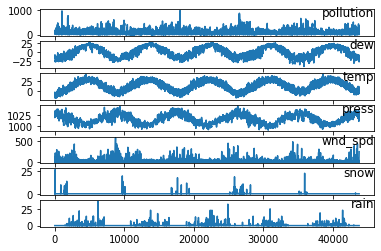

In [3]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

### Multivariate LSTM Forecast Model

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  
(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)
Epoch 1/50
122/122 - 17s - loss: 0.0605 - val_loss: 0.0493 - 17s/epoch - 137ms/step
Epoch 2/50
122/122 - 2s - loss: 0.0415 - val_loss: 0.0528 - 2s/epoch - 16ms/step
Epoch 3/50
122/122 - 2s - loss: 0.0244 - val_loss: 0.0487 - 2s/epoch - 15ms/step
Epoch 4/50
122/122 - 2s - loss: 0.0179 - val_loss: 0.0431 - 2s/epoc

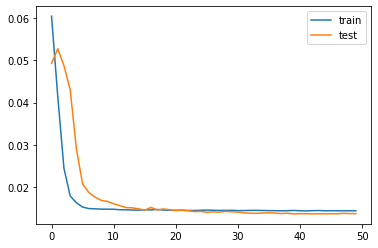

Test RMSE: 26.715


In [4]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())
 
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
 
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

### Train on multiple Lag Timesteps Example

(43797, 32)
(8760, 24) 8760 (8760,)
(8760, 3, 8) (8760,) (35037, 3, 8) (35037,)
Epoch 1/50
122/122 - 8s - loss: 0.0454 - val_loss: 0.0900 - 8s/epoch - 63ms/step
Epoch 2/50
122/122 - 2s - loss: 0.0276 - val_loss: 0.0605 - 2s/epoch - 19ms/step
Epoch 3/50
122/122 - 2s - loss: 0.0220 - val_loss: 0.0345 - 2s/epoch - 19ms/step
Epoch 4/50
122/122 - 2s - loss: 0.0214 - val_loss: 0.0301 - 2s/epoch - 20ms/step
Epoch 5/50
122/122 - 3s - loss: 0.0207 - val_loss: 0.0254 - 3s/epoch - 22ms/step
Epoch 6/50
122/122 - 2s - loss: 0.0201 - val_loss: 0.0225 - 2s/epoch - 19ms/step
Epoch 7/50
122/122 - 2s - loss: 0.0196 - val_loss: 0.0205 - 2s/epoch - 19ms/step
Epoch 8/50
122/122 - 2s - loss: 0.0191 - val_loss: 0.0201 - 2s/epoch - 19ms/step
Epoch 9/50
122/122 - 2s - loss: 0.0187 - val_loss: 0.0191 - 2s/epoch - 20ms/step
Epoch 10/50
122/122 - 2s - loss: 0.0181 - val_loss: 0.0191 - 2s/epoch - 19ms/step
Epoch 11/50
122/122 - 2s - loss: 0.0178 - val_loss: 0.0194 - 2s/epoch - 19ms/step
Epoch 12/50
122/122 - 2s - 

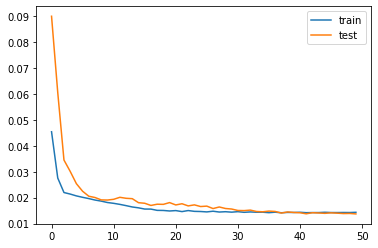

Test RMSE: 26.441


In [7]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
n_hours = 3
n_features = 8
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
print(reframed.shape)
 
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
 
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)